In [4]:
!ls train

Alice_log.csv  other_user_logs


In [5]:
!head train/Alice_log.csv

timestamp,site
2013-02-12 16:25:10,api.bing.com
2013-02-12 16:25:11,api.bing.com
2013-02-12 16:32:10,api.bing.com
2013-02-12 16:32:11,www.google.fr
2013-02-12 16:32:24,www.google.fr
2013-02-12 16:32:25,www.info-jeunes.net
2013-02-12 16:32:25,www.google.fr
2013-02-12 16:32:26,www.info-jeunes.net
2013-02-12 16:32:27,platform.twitter.com


In [96]:
import pandas as pd
import numpy as np

In [31]:
sites = ['site%s' % i for i in range(1, 11)]

df_train = pd.read_csv('train_sessions.csv', dtype={s: 'str' for s in sites})

In [45]:
parts = []

for i in range(1, 11):
    part = df_train[['session_id', 'time%d' % i, 'site%d' % i, 'target']]
    part = part.rename(columns={'time%d' % i: 'time', 'site%d' % i: 'site'})
    part = part.dropna()
    parts.append(part)

In [46]:
df_parts = pd.concat(parts)
df_parts = df_parts.sort_values(by='session_id', kind='mergesort').reset_index(drop=1)
df_parts.time = pd.to_datetime(df_parts.time)

In [50]:
df_alice = df_parts[df_parts.target == 1]

In [53]:
sessions = df_alice.sort_values(by='time')

In [55]:
sessions.time.diff()

2390199        NaT
2390200   00:00:01
2390201   00:06:59
2390202   00:00:01
2390203   00:00:13
2390204   00:00:01
2390205   00:00:00
2390206   00:00:01
2390207   00:00:01
2390208   00:00:00
1868918   00:00:00
1868919   00:00:01
1868920   00:00:01
1868921   00:00:05
1868922   00:00:01
1868923   00:00:00
1868925   00:00:07
1868924   00:00:00
1868926   00:00:09
1868927   00:00:02
1640992   00:00:00
1640993   00:00:18
1640994   00:00:01
1640995   00:00:01
1640996   00:00:02
1640998   00:00:09
1640997   00:00:00
1640999   00:00:09
1641000   00:00:01
1641001   00:00:12
            ...   
381600    00:00:07
381601    00:00:00
381602    00:00:00
381603    00:00:01
381604    00:00:01
381605    00:00:01
1956856   00:00:00
1956857   00:00:01
1956858   00:00:03
1956859   00:00:01
1956860   00:00:01
1956861   00:01:42
1956862   00:00:04
1956863   00:12:52
1956864   00:00:04
1956865   00:00:53
577399    00:07:32
577400    00:00:01
577401    00:00:01
577402    00:00:02
577403    00:00:11
577404    00

In [56]:
df_test = pd.read_csv('test_sessions.csv', dtype={s: 'str' for s in sites})

In [59]:
parts = []

for i in range(1, 11):
    part = df_test[['session_id', 'time%d' % i, 'site%d' % i]]
    part = part.rename(columns={'time%d' % i: 'time', 'site%d' % i: 'site'})
    part = part.dropna()
    parts.append(part)

In [60]:
df_parts_test = pd.concat(parts)
df_parts_test = df_parts_test.sort_values(by='session_id', kind='mergesort').reset_index(drop=1)
df_parts_test.time = pd.to_datetime(df_parts_test.time)

In [62]:
df_parts_test.time.min(), df_parts_test.time.max()

(Timestamp('2014-05-01 17:14:03'), Timestamp('2014-12-05 23:56:23'))

In [64]:
df_parts.time.min(), df_parts.time.max()

(Timestamp('2013-01-12 08:05:57'), Timestamp('2014-04-30 23:40:05'))

In [66]:
df_alice.time.max()

Timestamp('2014-04-15 18:07:50')

In [74]:
df_train_all = df_train

In [98]:
for s in sites:
    df_train_all[s].fillna('', inplace=1)

In [134]:
val_mask = pd.to_datetime(df_train_all.time1) > '2014-04-01 00:00:00'

In [135]:
df_train = df_train_all[~val_mask].reset_index(drop=True)
df_val = df_train_all[val_mask].reset_index(drop=True)

In [136]:
len(df_train), len(df_val)

(222357, 31204)

In [137]:
df_train.target.mean(), df_val.target.mean()

(0.008972058446552167, 0.009678246378669401)

In [138]:
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split

from time import time

In [139]:
df = df_train
df['sites'] = df.site1 + ' ' + df.site2 + ' ' + df.site3 + ' ' + df.site4 + ' ' + df.site5 + ' ' + \
              df.site6 + ' ' + df.site7 + ' ' + df.site8 + ' ' + df.site9 + ' ' + df.site10  

In [140]:
df = df_val
df['sites'] = df.site1 + ' ' + df.site2 + ' ' + df.site3 + ' ' + df.site4 + ' ' + df.site5 + ' ' + \
              df.site6 + ' ' + df.site7 + ' ' + df.site8 + ' ' + df.site9 + ' ' + df.site10  

In [141]:
cv = CountVectorizer(token_pattern='\S+', dtype=np.uint8, binary=True, min_df=10, max_df=0.5)
X_train = cv.fit_transform(df_train.sites)
y_train = df_train.target.values

In [142]:
X_val = cv.transform(df_val.sites)
y_val = df_val.target.values

In [159]:
for C in [0.01, 0.1, 0.5, 1]:
    t0 = time()

    svm = LinearSVC(penalty='l1', dual=False, C=C, random_state=1)
    svm.fit(X_train, y_train)

    y_pred = svm.decision_function(X_val)
    auc = roc_auc_score(y_val, y_pred)
    pr_auc = average_precision_score(y_val, y_pred)

    print('C=%s, took %.3fs, auc=%.3f, %.3f' % (C, time() - t0, auc, pr_auc))

C=0.01, took 0.392s, auc=0.850, 0.134
C=0.1, took 1.206s, auc=0.908, 0.226
C=0.5, took 2.078s, auc=0.922, 0.239
C=1, took 2.315s, auc=0.919, 0.234


In [151]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [160]:
p, r, _ = precision_recall_curve(y_val, y_pred)
average_precision = average_precision_score(y_val, y_pred)

In [148]:
import matplotlib.pyplot as plt
%matplotlib inline

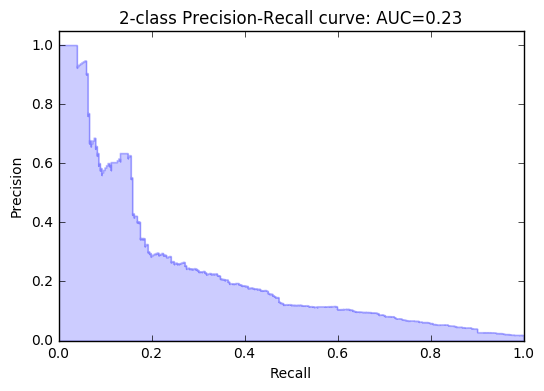

In [161]:
plt.step(r, p, color='b', alpha=0.2, where='post')
plt.fill_between(r, p, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
          average_precision))